# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
RANDOM_CEED = 12345

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RANDOM_CEED) 

Found 7591 validated image filenames.


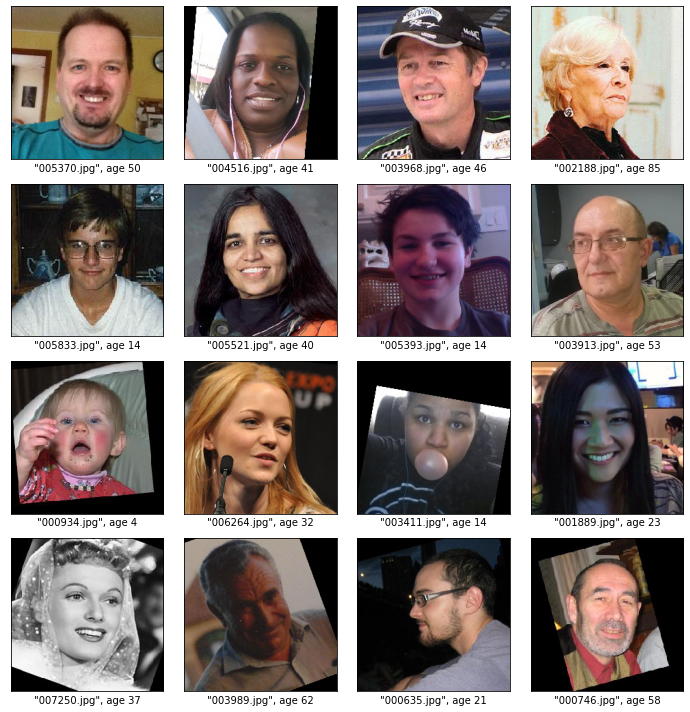

In [3]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1) 
    plt.imshow(gen_flow[0][0][i]) # i-тая картинка первого батча
    plt.xlabel(
        f'"{gen_flow.filenames[gen_flow.index_array[i]]}", age {gen_flow[0][1][i]}'
    )
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [4]:
labels.head(10)

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
5  000005.jpg        27
6  000006.jpg        24
7  000007.jpg        43
8  000008.jpg        26
9  000009.jpg        39

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe()

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

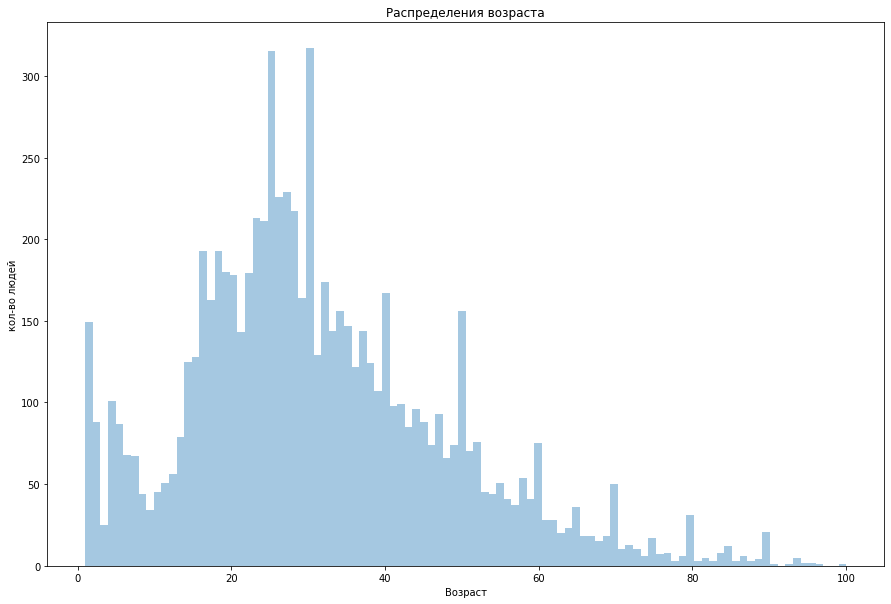

In [7]:
plt.figure(figsize=(15,10))
sns.distplot(labels['real_age'], bins=100, kde=False)
plt.title("Распределения возраста")
plt.xlabel("Возраст")
plt.ylabel("кол-во людей")
plt.show()

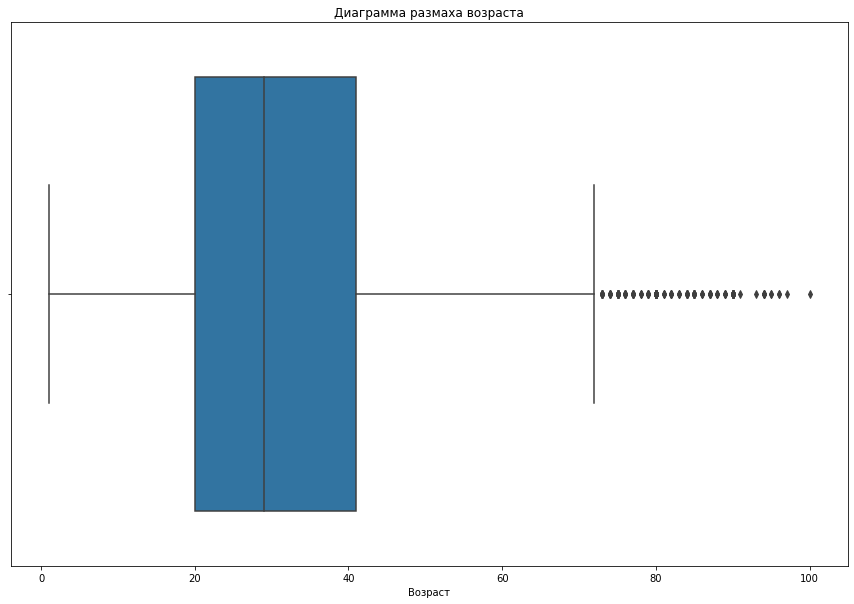

In [8]:
plt.figure(figsize=(15,10))
sns.boxplot(labels['real_age'])
plt.title("Диаграмма размаха возраста")
plt.xlabel("Возраст")
plt.show()

***Вывод:*** Файл содержит 7591 запись. Количество значений в столбцах совпадает, что говорит о том, что пропущенных значений нет. Распределение нормальное, с правым хвостом.

По избражениям заметно, первичная аугментация уже сделана: некоторые фотографии искажены и смещены. Предварительная аугментация не требуется. Это так же указано в описании датасета на сайте.

В датасете есть черно-белые фотографии, изображения могут различаться по повороту, обрезке, могут быть смещены. Размер изображений отличается, но при обработке это учтено.

Исходя из диаграммы размаха, большинство людей возрастом от 20 до 40. Выбросов немного, но это может незначительно исказить модель.

Присутствуют изображения людей в головном уборе, что может повлиять на точность определения возраста.

## Обучение модели

```python
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale= 1./255, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale= 1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

## Анализ обученной модели

***Вывод:*** Получен необходимый показатель метрики. MAE на валидационной выборке 6.1945. Для обучения модели применялась сверточная нейронная сеть ResNet50. Алгоритмом оптимизации Adam(lr=0.0001). Обучение на 10 эпохах.
